# Gradients

In [9]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'
import jax
import jax.numpy as jnp
import numpy as np
import jax.extend
import matplotlib.pyplot as plt

Everything works on the chain rule:

Suppose you have some computation expressed as a DAG:

$$ X_0 \rightarrow X_1 \rightarrow \dots \rightarrow X_k \rightarrow X_{k+1} \rightarrow \dots \rightarrow L$$

and we wish to compute the gradient $\frac{\partial L}{\partial X_0}$. The chain rule tells us that for any node $X_i$:

$$ \frac{\partial L}{\partial X_0} = \frac{\partial L}{\partial X_{k}}\frac{\partial X_{k}}{\partial X_0}$$

This suggests two ways that the gradient can be computed:

1. Reverse-mode: Use the chain rule $\frac{\partial L}{\partial X_k} = \frac{\partial L}{\partial X_{k+1}}\frac{\partial X_{k+1}}{\partial X_k}$

```python
start with dL/dX[N]
for k in N->0:
    dL/dX[k] = dL/dX[k+1] * dX[k+1]/dXk
```

2. Forward-mode: Use the chain rule $\frac{\partial X_{k+1}}{\partial X_0} = \frac{\partial X_{k+1}}{\partial X_k}\frac{\partial X_k}{\partial X_0}$

```python
start with dX[1]/dX[0]
for k in 1->N:
    dX[k+1]/dX[0] = dX[k+1]/dX[k] * dX[k]/dX[0]
dL/dX[0] = dL/dX[N] * dX[N]/dX[0]
```

In [13]:
rng = np.random.default_rng(0)
def generate_normal(shape, norm_axis=None):
    if norm_axis is not None:
        norm = np.sqrt(shape[norm_axis])
    else:
        norm = 1
    return jnp.asarray(rng.normal(size=shape)) / norm

x0 = generate_normal((1000, 32))
W1 = generate_normal((32, 128), norm_axis=0)
W2 = generate_normal((128, 1), norm_axis=0)
b1 = generate_normal((128,))
b2 = jnp.zeros((1,))
y_true = generate_normal((1000, 1))

x1 = x0 @ W1 + b1
x1_act = jnp.maximum(x1, 0)
x2 = x1_act @ W2 + b2
loss = ((x2 - y_true) ** 2).mean()

# Reverse mode (backprop)

In [10]:
class VJPOp:
    def forward(self, *args): # returns output + residuals needed for backward pass
        pass
    def backward(self, gradients, residuals): # returns gradients for each input
        pass

class Mul(VJPOp):
    def forward(self, X, w, b):
        return X @ w + b, (X, w)

    def backward(self, gradients, residuals):
        gradients # (bs, d2)
        X, w = residuals
        dLdX = gradients @ w.T
        dLdw = X.T @ gradients
        dLdb = gradients.sum(axis=0)
        return (dLdX, dLdw, dLdb)

class Relu(VJPOp):
    def forward(self, X):
        return jnp.maximum(X, 0), (X,)

    def backward(self, gradients, residuals):
        X = residuals[0]
        return (gradients * (X > 0),)

class MSELoss(VJPOp):
    def forward(self, y_pred, y_true):
        return ((y_pred - y_true) ** 2).mean(), (y_pred, y_true)

    def backward(self, gradients, residuals):
        y_pred, y_true = residuals
        n = np.prod(y_pred.shape)
        return gradients * (2 * (y_pred - y_true) / n), gradients * (2 * (y_true - y_pred) / n)

In [11]:


def ours(x0, W1, b1, W2, b2, y_true):
    x1, x1_resid = Mul().forward(x0, W1, b1)
    x1_act, x1_act_resid = Relu().forward(x1)
    x2, x2_resid = Mul().forward(x1_act, W2, b2)
    loss, loss_resid = MSELoss().forward(x2, y_true)

    dLdL = 1
    dLdx2, _ = MSELoss().backward(dLdL, loss_resid)
    dLdx1_act, dLdW2, dLdb2 = Mul().backward(dLdx2, x2_resid)
    dLdx1, = Relu().backward(dLdx1_act, x1_act_resid)
    dLdx0, dLdW1, dLdb1 = Mul().backward(dLdx1, x1_resid)
    return locals()

def automatic(inputs):
    def f(inputs):
        x0, W1, b1, W2, b2, y_true = inputs["x0"], inputs["W1"], inputs["b1"], inputs["W2"], inputs["b2"], inputs["y_true"]
        x1 = x0 @ W1 + b1
        x1_act = jnp.maximum(x1, 0)
        x2 = x1_act @ W2 + b2
        loss = ((x2 - y_true) ** 2).mean()
        return loss, {"x1": x1, "x1_act": x1_act, "x2": x2}
    (loss, info), grads = jax.value_and_grad(f, has_aux=True)(inputs)
    return {**info, **{f"dLd{k}": v for k, v in grads.items()}}

In [21]:
our_outputs = ours(x0, W1, b1, W2, b2, y_true)
automatic_outputs = automatic({"x0": x0, "W1": W1, "b1": b1, "W2": W2, "b2": b2, "y_true": y_true})
for k in set(our_outputs.keys()) & set(automatic_outputs.keys()):
    print(k, jnp.linalg.norm(our_outputs[k] - automatic_outputs[k]))

dLdx0 8.370422e-09
dLdW2 7.4897803e-06
dLdW1 1.05462895e-07
x1_act 0.0
dLdb2 2.3841858e-07
x2 0.0
dLdb1 1.1267865e-07
x1 0.0


# Forward mode

In [14]:
class JVPOp:
    def forward(self, *args): 
        # takes in tuples of (i, di/dx)
        # returns tuples of (o, do/dx)
        pass

class Mul(JVPOp):
    def forward(self, X, w, b):
        X, dx = X
        w, dw = w
        b, db = b
        # assume that dw, db = 0
        return X @ w + b, dx @ w

class Relu(JVPOp):
    def forward(self, X):
        X, dx = X
        return jnp.maximum(X, 0), dx * (X > 0)

class MSELoss(JVPOp):
    def forward(self, y_pred, y_true):
        y_pred, dy_pred = y_pred
        y_true, dy_true = y_true    
        n = np.prod(y_pred.shape)
        return ((y_pred - y_true) ** 2).mean(), dy_pred @ (2 * (y_pred - y_true) / n)


In [56]:
def ours(x0, W1, b1, W2, b2, y_true):
    dx0dx0 = jnp.eye(x0.shape[1])
    x1, dx1dx0 = Mul().forward((x0, dx0dx0), (W1, 0), (b1, 0))
    x1_act, dx1_actdx0 = Relu().forward((x1, dx1dx0))
    x2, dx2dx0 = Mul().forward((x1_act, dx1_actdx0), (W2, 0), (b2, 0))
    loss, dlossdx0 = MSELoss().forward((x2, dx2dx0), (y_true, 0))
    return {k: v.T for k, v in locals().items() if 'dx0' in k}

def automatic(inputs):
    def f(x0):
        x0 = x0[None]
        x1 = x0 @ inputs["W1"] + inputs["b1"]
        x1_act = jnp.maximum(x1, 0)
        x2 = x1_act @ inputs["W2"] + inputs["b2"]
        loss = ((x2 - inputs["y_true"]) ** 2).mean()
        return {"dx0dx0": x0[0], "dx1dx0": x1[0], "dx1_actdx0": x1_act[0], "dx2dx0": x2[0], "loss": loss[None]}
    return jax.jacfwd(f)(inputs["x0"][0])


In [55]:
automatic_outputs = automatic({"x0": x0[:1], "W1": W1, "b1": b1, "W2": W2, "b2": b2, "y_true": y_true[:1]})
our_outputs = ours(x0[:1], W1, b1, W2, b2, y_true[:1])
for k in set(our_outputs.keys()) & set(automatic_outputs.keys()):
    print(k, jnp.linalg.norm(our_outputs[k] - automatic_outputs[k]))

x2.shape=(1, 1), dx2dx0.shape=(32, 1)
dx1_actdx0 0.0
dx2dx0 5.934944e-08
dx1dx0 0.0
dx0dx0 0.0


# MLP in Numpy

In [60]:
import mnist
mnist.datasets_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

images = mnist.train_images()
labels = mnist.train_labels()

In [66]:
X.shape

(60000, 784)

In [70]:
import tqdm
X = images.reshape(images.shape[0], -1)
X = X.astype(jnp.float32) / 127.5 - 1
y = labels.astype(jnp.int32)

def init_params(rng: np.random.Generator):
    W1 = jnp.asarray(rng.normal(size=(28 * 28, 128))) / np.sqrt(28 * 28)
    b1 = jnp.zeros((128,))
    W2 = jnp.asarray(rng.normal(size=(128, 10))) / np.sqrt(128)
    b2 = jnp.zeros((10,))
    return (W1, b1), (W2, b2)

def model(x, params):
    for W, b in params[:-1]:
        x = jnp.maximum(x @ W + b, 0)
    logits = x @ params[-1][0] + params[-1][1]
    logits = logits - logits.max(axis=-1, keepdims=True) # Numerical stability
    logits = jnp.exp(logits)
    probs = logits / logits.sum(axis=-1, keepdims=True)
    return probs

    return jax.nn.softmax(x @ params[-1][0] + params[-1][1], axis=-1)

def get_metrics(params, X, y, bs=1000):
    accs = []
    losses = []
    for i in tqdm.trange(0, X.shape[0], bs):
        x = X[i:i+bs]
        y_pred = model(x, params)
        y_true = y[i:i+bs]
        acc = (y_pred.argmax(axis=-1) == y_true).mean()
        loss = -jnp.log(y_pred[jnp.arange(bs), y_true]).mean()
        accs.append(acc)
        losses.append(loss)
    return {
        'acc': jnp.array(accs).mean(),
        'loss': jnp.array(losses).mean()
    }


In [71]:
params = init_params(rng)
get_metrics(params, X, y)

100%|██████████| 60/60 [00:00<00:00, 647.99it/s]


{'acc': Array(0.09485, dtype=float32), 'loss': Array(2.7404664, dtype=float32)}

In [106]:
def get_loss_and_grads(x, labels, params):
    intermediates = []
    for n, (W, b) in enumerate(params):
        last_x = x
        x = post_linear = x @ W + b
        if n != len(params) - 1:
            x = jnp.maximum(x, 0)
        intermediates.append((last_x, post_linear))
    logits = x - x.max(axis=-1, keepdims=True) # Numerical stability
    logits = jnp.exp(logits)
    probs = logits / logits.sum(axis=-1, keepdims=True)
    one_hot = jax.nn.one_hot(labels, 10)
    loss = -(jnp.log(probs) * one_hot).sum(-1).mean()
    accuracy = (probs.argmax(axis=-1) == labels).mean()

    dLdx = dLdlogits = -1 * (jax.nn.one_hot(labels, 10) - probs) / probs.shape[0] # (bs, 10)
    deltas = []
    for n, (x, x_act) in zip(range(len(params)-1, -1, -1), reversed(intermediates)):
        if n != len(params) - 1:
            dLdx_act = dLdx * (x_act > 0) # ReLU
        else:
            dLdx_act = dLdx
        # dLdx_act = (bs, d2)
        dLdx = dLdx_act @ params[n][0].T # (bs, d1)
        dLdw = x.T @ dLdx_act # (d1, d2)
        dLdb = dLdx_act.sum(0)
        deltas.append((dLdw, dLdb))
    return loss, accuracy, tuple(deltas[::-1])

In [88]:
jax.tree.map(lambda x: x.shape, get_loss_and_grads(*sample_batch(rng, X, y), params))

((), (), [((784, 128), (128,)), ((128, 10), (10,))])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 220.85it/s]


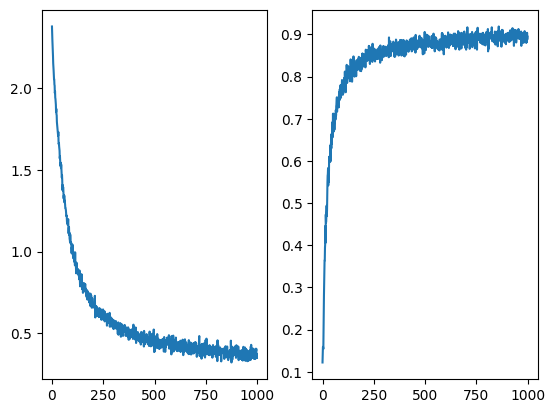

In [110]:
def sample_batch(rng, X, y, bs=1000):
    i = rng.integers(0, X.shape[0], bs)
    return X[i], y[i]

def run_sgd(params, batch, lr=1e-2):
    loss, accuracy, deltas = get_loss_and_grads(*batch, params)
    new_params = []
    for (W, b), (dLdw, dLdb) in zip(params, deltas):
        new_params.append((W - lr * dLdw, b - lr * dLdb))
    return new_params, loss, accuracy

rng = np.random.default_rng(0)
params = init_params(rng)
losses = []
accuracies = []
for i in tqdm.trange(1000):
    params, loss, accuracy = run_sgd(params, sample_batch(rng, X, y))
    losses.append(loss)
    accuracies.append(accuracy)

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy")


In [ ]:
import dataclasses
@dataclasses.dataclass
class Adam:
    params: list[tuple[jnp.ndarray, jnp.ndarray]]
    momentum: list[tuple[jnp.ndarray, jnp.ndarray]]
    momentum2: list[tuple[jnp.ndarray, jnp.ndarray]]
    b1: float
    b2: float
    eps: float
    lr: float

    @classmethod
    def create(cls, params, lr=1e-3, b1=0.9, b2=0.999, eps=1e-8):
        momentum = jax.tree.map(lambda p: jnp.zeros_like(p), params)
        momentum2 = jax.tree.map(lambda p: jnp.zeros_like(p), params)
        return cls(params, momentum, momentum2, b1, b2, eps, lr)

def run_adam(state: Adam, batch):
    loss, accuracy, deltas = get_loss_and_grads(*batch, state.params)
    b1, b2, eps, lr = state.b1, state.b2, state.eps, state.lr
    new_momentum = jax.tree.map(lambda m, g: b1 * m + (1 - b1) * g, state.momentum, deltas)
    new_momentum2 = jax.tree.map(lambda m2, g: b2 * m2 + (1 - b2) * g ** 2, state.momentum2, deltas)
    new_params = jax.tree.map(lambda p, m, m2: p - lr * m / (eps + jnp.sqrt(m2)), state.params, new_momentum, new_momentum2)
    return dataclasses.replace(state, params=new_params, momentum=new_momentum, momentum2=new_momentum2), loss, accuracy

rng = np.random.default_rng(0)
params = init_params(rng)
state = Adam.create(params)
adam_losses = []
adam_accuracies = []
for i in tqdm.trange(1000):
    state, loss, accuracy = run_adam(state, sample_batch(rng, X, y))
    adam_losses.append(loss)
    adam_accuracies.append(accuracy)

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.plot(adam_losses, label="Adam Loss")
plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy")
plt.plot(adam_accuracies, label="Adam Accuracy")
plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

 54%|█████▍    | 538/1000 [00:03<00:02, 159.75it/s]